In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
import marimo as mo

In [102]:
base_dir = "/root/vllm/benchmarks/result"
replace_name = {
    "fcfs": "FCFS",
    "las": "LAS",
    "srjf": "SRJF",
    "sjf": "SJF",
    "tfittradeoff": "TFITTradeoff",
}

In [103]:
# 1 gpu_device: if output_len < 10  or prompt_len > 128:
# _dates = ["20241202","20241203"]
# _counters= [[63,64,70,71,72,74],[75,76,77]]

# 4 gpu_devices: if output_len < 10  or prompt_len > 128:
_dates = ["20241205","20241206","20241207", "20241208"]
_counters = [[108],[115,116, 117, 118],[120,121, 122, 123, 129, 130, 131, 132, 133, 134], [140, 141]] # , [135, 136, 137, 138, 139]

e2e_result_dir_names = []
for i in range(len(_dates)):
    _date = _dates[i]
    _counter = _counters[i]
    e2e_result_dir_names.extend([os.path.join(base_dir, _date, str(counter)) for counter in _counter])

In [104]:
e2e_result_dfs = {}
for dir_name in e2e_result_dir_names:
    for file in os.listdir(dir_name):
        if file.endswith(".json"):
            # print(file)
            with open(os.path.join(dir_name, file), "r") as f:
                data = json.load(f)
            # print(data)
            e2e_result_df = pd.DataFrame(data)
            e2e_result_df.drop(
                columns=[
                    "date",
                    "backend",
                    "tokenizer_id",
                    "best_of",
                    "use_beam_search",
                ],
                inplace=True,
            )
            e2e_result_df.replace(
                replace_name,
                inplace=True,
            )
            e2e_result_dfs[file] = e2e_result_df

In [105]:
def add_num_annotation(ax, rotation=0, fontsize=10):
    for _p in ax.patches:
        if _p.get_height() == 0:
            continue
        ax.annotate(
            str(round(_p.get_height(), 2)),
            (_p.get_x() + _p.get_width() / 2.0, _p.get_height() * 1.05),
            ha="center",
            va="center",
            xytext=(0, 6),
            textcoords="offset points",
            rotation=rotation,
            fontsize=fontsize,
        )

In [106]:
def get_tp_ratio(df):
    print(df)
    min_result = df["output_throughput"].min()
    df["output_throughput"] = df["output_throughput"] / 1
    return df

In [107]:
def e2e_result(
    add_num_annotation,
    e2e_result_dfs,
    get_tp_ratio,
    pd,
    plt,
    sns,
):
    e2e_result = {
        "scheduling_policies": [],
        "swap_policies": [],
        "request_throughput": [],
        "output_throughput": [],
        "request_rates": [],
    }
    for _df_name in e2e_result_dfs:
        _tmp_df = e2e_result_dfs[_df_name]
        e2e_result["scheduling_policies"].append(
            _tmp_df["scheduler_policy"].iloc[0]
        )
        e2e_result["swap_policies"].append(_tmp_df["swap_policy"].iloc[0])
        e2e_result["request_throughput"].append(
            _tmp_df["request_throughput"].mean()
        )
        e2e_result["request_rates"].append(_tmp_df["request_rate"].iloc[0])
        e2e_result["output_throughput"].append(_tmp_df["output_throughput"].mean())

    _result_df = pd.DataFrame(e2e_result)

    _result_df = (
        _result_df.groupby(
            ["scheduling_policies", "swap_policies", "request_rates"]
        )
        .max()
        .reset_index()
    )
    _result_df = (
        _result_df.groupby(
            ["swap_policies", "request_rates"],
            group_keys=False,
        )
        .apply(lambda row: get_tp_ratio(row))
        .reset_index()
    )
    sns.set_style(style="whitegrid")
    sns.set_palette("deep")
    fig, axes = plt.subplots(
        2,
        1,
        figsize=(10, 4),
        dpi=150,
    )
    sns.barplot(
        data=_result_df,
        x="request_rates",
        y="request_throughput",
        hue="scheduling_policies",
        ax=axes[0],
        width=0.7
    )
    add_num_annotation(axes[0], rotation=90)
    axes[0].legend(
        title="",
        frameon=False,
        ncol=3,
        loc=(0, 1),
        handlelength=1.0,
        columnspacing=0.5,
    )
    axes[0].set_ylim(0, 2.0)
    axes[0].set_ylabel("Throughput (requests/s)")
    axes[0].set_xlabel("Request Rate (r/s)")
    axes[0].grid(linestyle="--", alpha=0.5, axis="y")
    sns.barplot(
        data=_result_df,
        x="request_rates",
        y="output_throughput",
        hue="scheduling_policies",
        legend=False,
        ax=axes[1],
        width=0.7,
    )
    add_num_annotation(axes[1], rotation=90)
    # axes[1].set_ylim(0, 600\
    axes[1].set_ylabel("Throughput (Token/s)")
    axes[1].set_xlabel("Request Rate (r/s)")
    axes[1].grid(linestyle="--", alpha=0.5, axis="y")
    plt.show()

In [108]:
selected_result = {
    "scheduler_policy": [],
    "swap_policy": [],
    "request_rate": [],
}
selected_columns = [
    "mean_ttft_ms",
    "median_ttft_ms",
    "p99_ttft_ms",
    "mean_tpot_ms",
    "median_tpot_ms",
    "p99_tpot_ms",
    "mean_itl_ms",
    "median_itl_ms",
    "p99_itl_ms",
    "mean_lat_ms",
    "median_lat_ms",
    "p99_lat_ms",
]
for _column in selected_columns:
    selected_result[_column] = []
for _df_name in e2e_result_dfs:
    tmp_df = e2e_result_dfs[_df_name]
    for _column in selected_result:
        if _column in tmp_df.columns:
            if isinstance(tmp_df[_column][0], float):
                selected_result[_column].append(tmp_df[_column].min())
            else:
                selected_result[_column].append(tmp_df[_column][0])

In [109]:
def get_metric_ratio(df):
    min_result = df["Value"].min()
    df["Ratio"] = df["Value"] / min_result
    return df


_result_df = pd.DataFrame(selected_result)
_result_df = (
    _result_df.groupby(["scheduler_policy", "swap_policy", "request_rate"])
    .mean()
    .reset_index()
)
_long_df = _result_df[
    ["scheduler_policy", "swap_policy", "request_rate"] + selected_columns
]
_long_df = _long_df.melt(
    id_vars=["scheduler_policy", "swap_policy", "request_rate"],
    value_vars=selected_columns,
    var_name="Metric",
    value_name="Value",
)
_long_df = (
    _long_df.groupby(
        ["Metric", "request_rate"],
        group_keys=False,
    )
    .apply(lambda row: get_metric_ratio(row))
    .reset_index()
)

_long_df[["metric_name", "metric_type"]] = _long_df["Metric"].apply(
    lambda row: pd.Series(
        [row.split("_", 2)[0].capitalize(), row.split("_", 2)[1].upper()]
    )
)
# _long_df = _long_df[_long_df["metric_name"] == "P99"]



/tmp/ipykernel_1970679/247932586.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio(row))


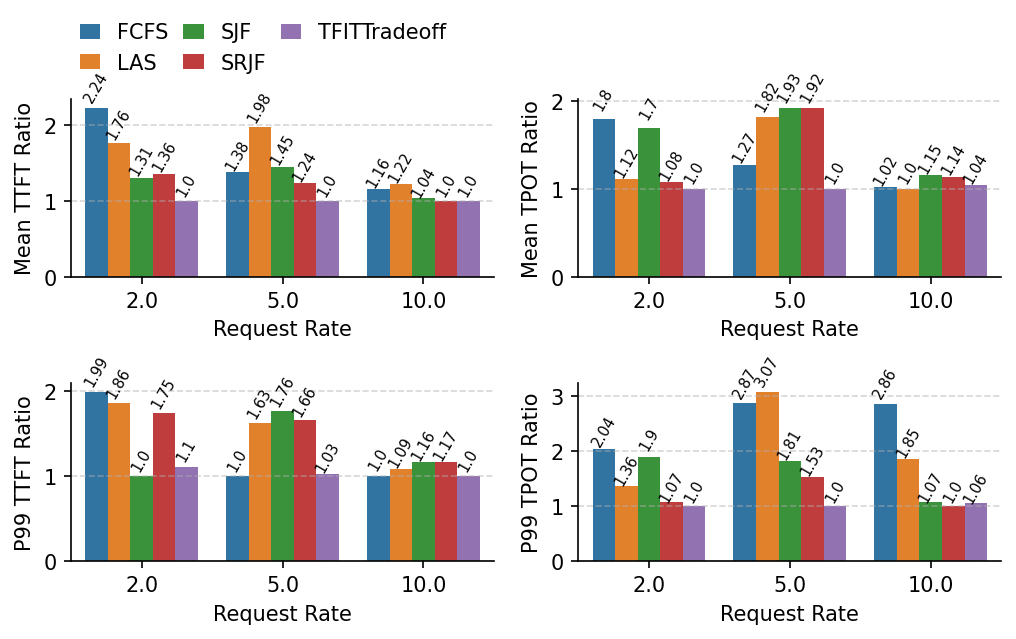

In [110]:
def bar_plot_1(_long_df, required_metric_name):
    (_fig, _ax) = plt.subplots(
        figsize=(4 * 2, 2 * 2), dpi=150, nrows=2, ncols=2
    )
    
    for metric_name in _long_df["metric_name"].unique().tolist():
        if required_metric_name != metric_name:
            _long_df = _long_df[_long_df["metric_name"] != metric_name]
    metric_types = _long_df["metric_type"].unique().tolist()
    metric_names = _long_df["metric_name"].unique().tolist()
    scheduler_policies = _long_df["scheduler_policy"].unique().tolist()

    save_legend = True
    for _i, metric_type in enumerate(metric_types):
        if _i > 0:
            save_legend = False

        data = _long_df[(_long_df["metric_type"] == metric_type)]

        ax = sns.barplot(
            x="request_rate",  
            y="Ratio",        
            hue="scheduler_policy",  
            data=data,
            ax=_ax[_i // 2][_i % 2]
        )
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        _ax[_i // 2][_i % 2].set_xlabel("Request Rate")
        # _ax[_i // 2][_i % 2].set_ylabel(_long_df["metric_name"].unique().tolist()[0] + " " + metric_type+" Ratio")

        add_num_annotation(_ax[_i // 2][_i % 2], rotation=60, fontsize=7)
        
        _ax[_i // 2][_i % 2].grid(linestyle="--", alpha=0.5, axis="y")
        
        if _i == 0:
            _ax[_i // 2][_i % 2].legend(
                title="",
                frameon=False,
                ncol=3,
                loc=(0, 1.1),
                
                
                handlelength=1.0,
                columnspacing=0.7,
            )
        else:
            _ax[_i // 2][_i % 2].legend().remove()

def bar_plot_2(_long_df,  required_metric_name_list, required_metric_type_list):
    (_fig, _ax) = plt.subplots(
        figsize=(4 * 2, 2*2), dpi=150, nrows=2, ncols=2
    )
    _long_df = _long_df[((_long_df['metric_name']==required_metric_name_list[0])
                    &(_long_df['metric_type']==required_metric_type_list[0]))|((_long_df['metric_name']==required_metric_name_list[0])
                    &(_long_df['metric_type']==required_metric_type_list[1]))|((_long_df['metric_name']==required_metric_name_list[1])
                    &(_long_df['metric_type']==required_metric_type_list[0]))|((_long_df['metric_name']==required_metric_name_list[1])
                    &(_long_df['metric_type']==required_metric_type_list[1]))]
    metric_types = _long_df["metric_type"].unique().tolist()
    metric_names = _long_df["metric_name"].unique().tolist()
    scheduler_policies = _long_df["scheduler_policy"].unique().tolist()
    metrics = [(required_metric_name_list[0],required_metric_type_list[0]),(required_metric_name_list[0],required_metric_type_list[1]),
               (required_metric_name_list[1],required_metric_type_list[0]),(required_metric_name_list[1],required_metric_type_list[1])]
    save_legend = True
    for _i, (metric_name,metric_type) in enumerate(metrics):
        if _i > 0:
            save_legend = False

        data = _long_df[(_long_df["metric_type"] == metric_type)&(_long_df["metric_name"] == metric_name)]
        ax = sns.barplot(
            x="request_rate",  
            y="Ratio",        
            hue="scheduler_policy",  
            data=data,
            ax=_ax[_i // 2][_i % 2]
        )
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        _ax[_i // 2][_i % 2].set_xlabel("Request Rate")
        _ax[_i // 2][_i % 2].set_ylabel(metrics[_i][0] + " " + metrics[_i][1]+" Ratio")

        add_num_annotation(_ax[_i // 2][_i % 2], rotation=60, fontsize=7)
        
        _ax[_i // 2][_i % 2].grid(linestyle="--", alpha=0.5, axis="y")
        
        if _i == 0:
            _ax[_i // 2][_i % 2].legend(
                title="",
                frameon=False,
                ncol=3,
                loc=(0, 1.1),
                
                
                handlelength=1.0,
                columnspacing=0.7,
            )
        else:
            _ax[_i // 2][_i % 2].legend().remove()

required_metric_name = "P99"
# bar_plot_1(_long_df, required_metric_name=required_metric_name)
required_metric_name_list = ['Mean', 'P99']
required_metric_type_list = ['TTFT', 'TPOT']
bar_plot_2(_long_df, required_metric_name_list, required_metric_type_list)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
# plt.savefig(f"{required_metric_name}.pdf", format='pdf')
plt.show()

In [111]:
request_level_result = pd.DataFrame()
for _df_name in e2e_result_dfs:
    _tmp_df = e2e_result_dfs[_df_name].copy()
    _tmp_df["request_level_p99_itls"] = _tmp_df["itls"].apply(
        lambda row: 0 if len(row) == 0 else np.percentile(row, 99)
    )
    _tmp_df.drop(
        columns=[
            "model_id",
            "swap_space",
            "preemption_mode",
            "max_num_seqs",
            "swap_policy",
            "iter_theshold",
            "swap_out_partial_rate",
            "waiting_iter_base",
            "duration",
            "completed",
            "total_input_tokens",
            "total_output_tokens",
            "median_tpot_ms",
            "median_itl_ms",
            "median_lat_ms",
            "input_lens",
            "output_lens",
            "itls",
        ],
        inplace=True,
    )
    request_level_result = pd.concat([request_level_result, _tmp_df], axis=0)

/tmp/ipykernel_1970679/2090706351.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _df: _df["request_level_p99_itls"].quantile(0.99))
/tmp/ipykernel_1970679/2090706351.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_p99_ratio(row))


Text(0, 0.5, 'P99 ITL')

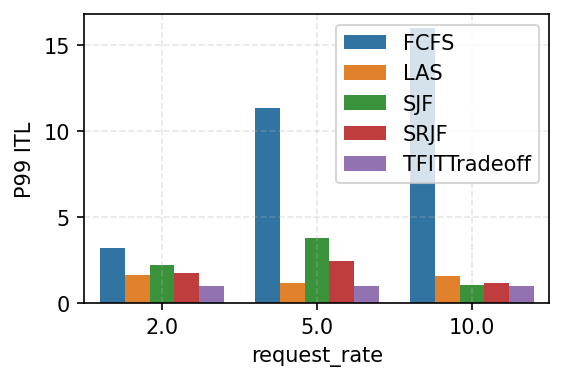

In [112]:
def get_p99_ratio(df):
    min_result = df["itls_p99"].min()
    df["itls_p99"] = df["itls_p99"] / min_result
    return df


_request_level_itls_p99_max = (
    request_level_result.groupby(["scheduler_policy", "request_rate"])
    .apply(lambda _df: _df["request_level_p99_itls"].quantile(0.99))
    .reset_index()
)
_request_level_itls_p99_max.columns = [
    "scheduler_policy",
    "request_rate",
    "itls_p99",
]
_request_level_itls_p99_max = (
    _request_level_itls_p99_max.groupby(
        ["request_rate"],
        group_keys=False,
    )
    .apply(lambda row: get_p99_ratio(row))
    .reset_index()
)
plt.figure(figsize=(4, 2.5), dpi=150)
sns.barplot(
    data=_request_level_itls_p99_max,
    x="request_rate",
    y="itls_p99",
    hue="scheduler_policy",
)
plt.legend(title="")
plt.grid(alpha=0.3, linestyle="--")
plt.ylabel("P99 ITL")

/tmp/ipykernel_1970679/556890840.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_max_mean_ttft_ratio(row))


Text(0, 0.5, 'Median TTFT')

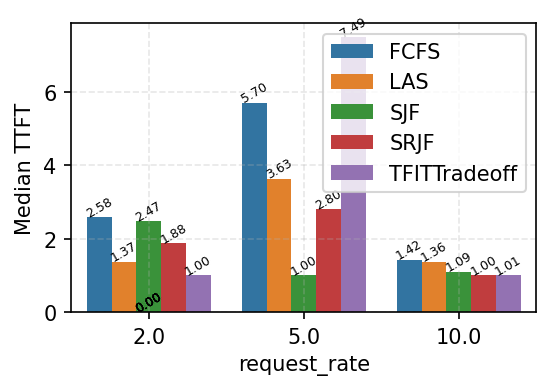

In [113]:
def get_max_mean_ttft_ratio(df):
    min_result = df["median_ttft_ms"].min()
    df["median_ttft_ms"] = df["median_ttft_ms"] / min_result
    return df


_request_level_mean_ttfts_max = (
    request_level_result.groupby(["scheduler_policy", "request_rate"])
    .agg({"median_ttft_ms": "median"})
    .reset_index()
)
_request_level_mean_ttfts_max.columns = [
    "scheduler_policy",
    "request_rate",
    "median_ttft_ms",
]
_request_level_mean_ttfts_max = (
    _request_level_mean_ttfts_max.groupby(
        ["request_rate"],
        group_keys=False,
    )
    .apply(lambda row: get_max_mean_ttft_ratio(row))
    .reset_index()
)
plt.figure(figsize=(4, 2.5), dpi=150)
ax = sns.barplot(
    data=_request_level_mean_ttfts_max,
    x="request_rate",
    y="median_ttft_ms",
    hue="scheduler_policy",
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        format(height, '.2f'),  # Format the number to two decimal places
        (p.get_x() + p.get_width() / 2., height),  # Position of the label
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 5),  # Offset of the label
        textcoords='offset points',
        rotation=30,
        fontsize=6,
    )

plt.legend(title="")
plt.grid(alpha=0.3, linestyle="--")
plt.ylabel("Median TTFT")

# Source of Improvement

In [114]:
_dates = ["20241205"]
_counters = [[108,111]]
schedule_policies = ["sjf","las","srjf","fcfs","tfittradeoff"]
execute_result_dir_names = []
for i in range(len(_dates)):
    _date = _dates[i]
    _counter = _counters[i]
    execute_result_dir_names.extend([os.path.join(base_dir, _date, str(counter)) for counter in _counter])

In [115]:
# For Motivation
execute_result_dfs_moti = {}
for _dir_name in execute_result_dir_names:
    for _file in os.listdir(_dir_name):
        if (
            _file.endswith(".csv")
            and "_detailed" in _file
            and "5.0qps" in _file      # Need to change
        ):
            _detailed_result_df = pd.read_csv(os.path.join(_dir_name, _file))
            _detailed_result_df["gpu memory iter"] = (
                _detailed_result_df["gpu memory iter"]
            )
            _detailed_result_df["gpu computation iter"] = (
                _detailed_result_df["gpu computation iter"]
                / 6900
            )
            for policy in schedule_policies:
                if policy in _file:
                    execute_result_dfs_moti[policy.upper()]=_detailed_result_df

In [116]:
execute_result_execution_time = pd.DataFrame()
for policy in execute_result_dfs_moti.keys():
    execute_result_dfs_moti[policy]['policy'] = policy
    execute_result_dfs_moti[policy]['time each iteration'] = execute_result_dfs_moti[policy]['execution time']/execute_result_dfs_moti[policy]['total iteration number']
    _tmp_df = execute_result_dfs_moti[policy].iloc[-1:, :]
    execute_result_execution_time = pd.concat([execute_result_execution_time, _tmp_df], axis=0)

execute_result_execution_time = execute_result_execution_time[[col for col in execute_result_execution_time.columns if col=='policy' or "time" in col or "iteration number" in col]]
execute_result_execution_time = execute_result_execution_time.melt(id_vars='policy', var_name='metric', value_name='value')

([0], [Text(0, 0, 'time each iteration')])

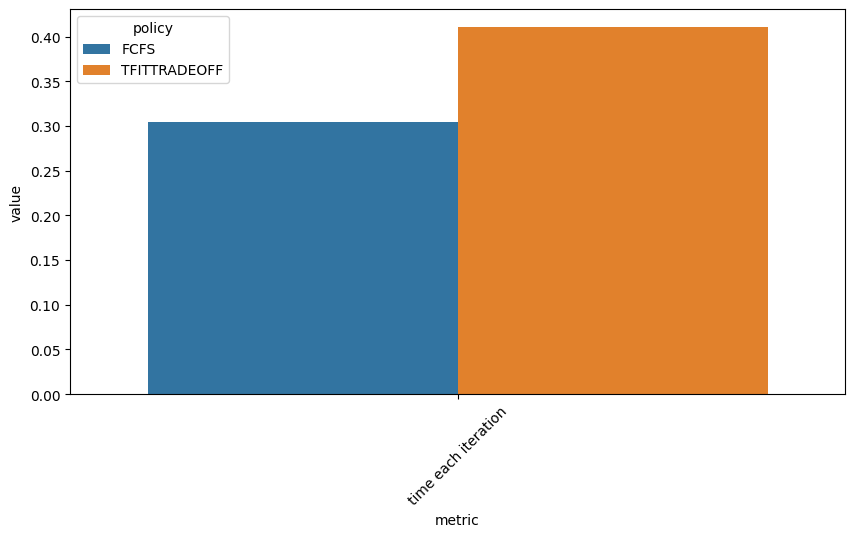

In [117]:
plt.figure(figsize=(10,5))
sns.barplot(x='metric',y='value',hue='policy',data=execute_result_execution_time[execute_result_execution_time['metric']=='time each iteration'])
# plt.yscale("log")
plt.xticks(rotation=45)

## Runtime Analysis 

In [118]:
execute_result_dfs = {}
for _dir_name in execute_result_dir_names:
    for _file in os.listdir(_dir_name):
        if (
            _file.endswith(".csv")
            and "_detailed" not in _file
            and "2.0qps" in _file      # Need to change
        ):
            _detailed_result_df = pd.read_csv(os.path.join(_dir_name, _file))
            _detailed_result_df["Cache Efficiency"] = (
                _detailed_result_df["Running"]
                / _detailed_result_df["GPU KV cache usage"]
            )
            for policy in schedule_policies:
                if policy in _file:
                    execute_result_dfs[policy.upper()]=_detailed_result_df
policies = list(execute_result_dfs.keys())

In [119]:
for policy in execute_result_dfs:
    print(policy, execute_result_dfs[policy][:591]['Swapped'].mean())

<Axes: title={'center': 'Cache Efficiency'}>

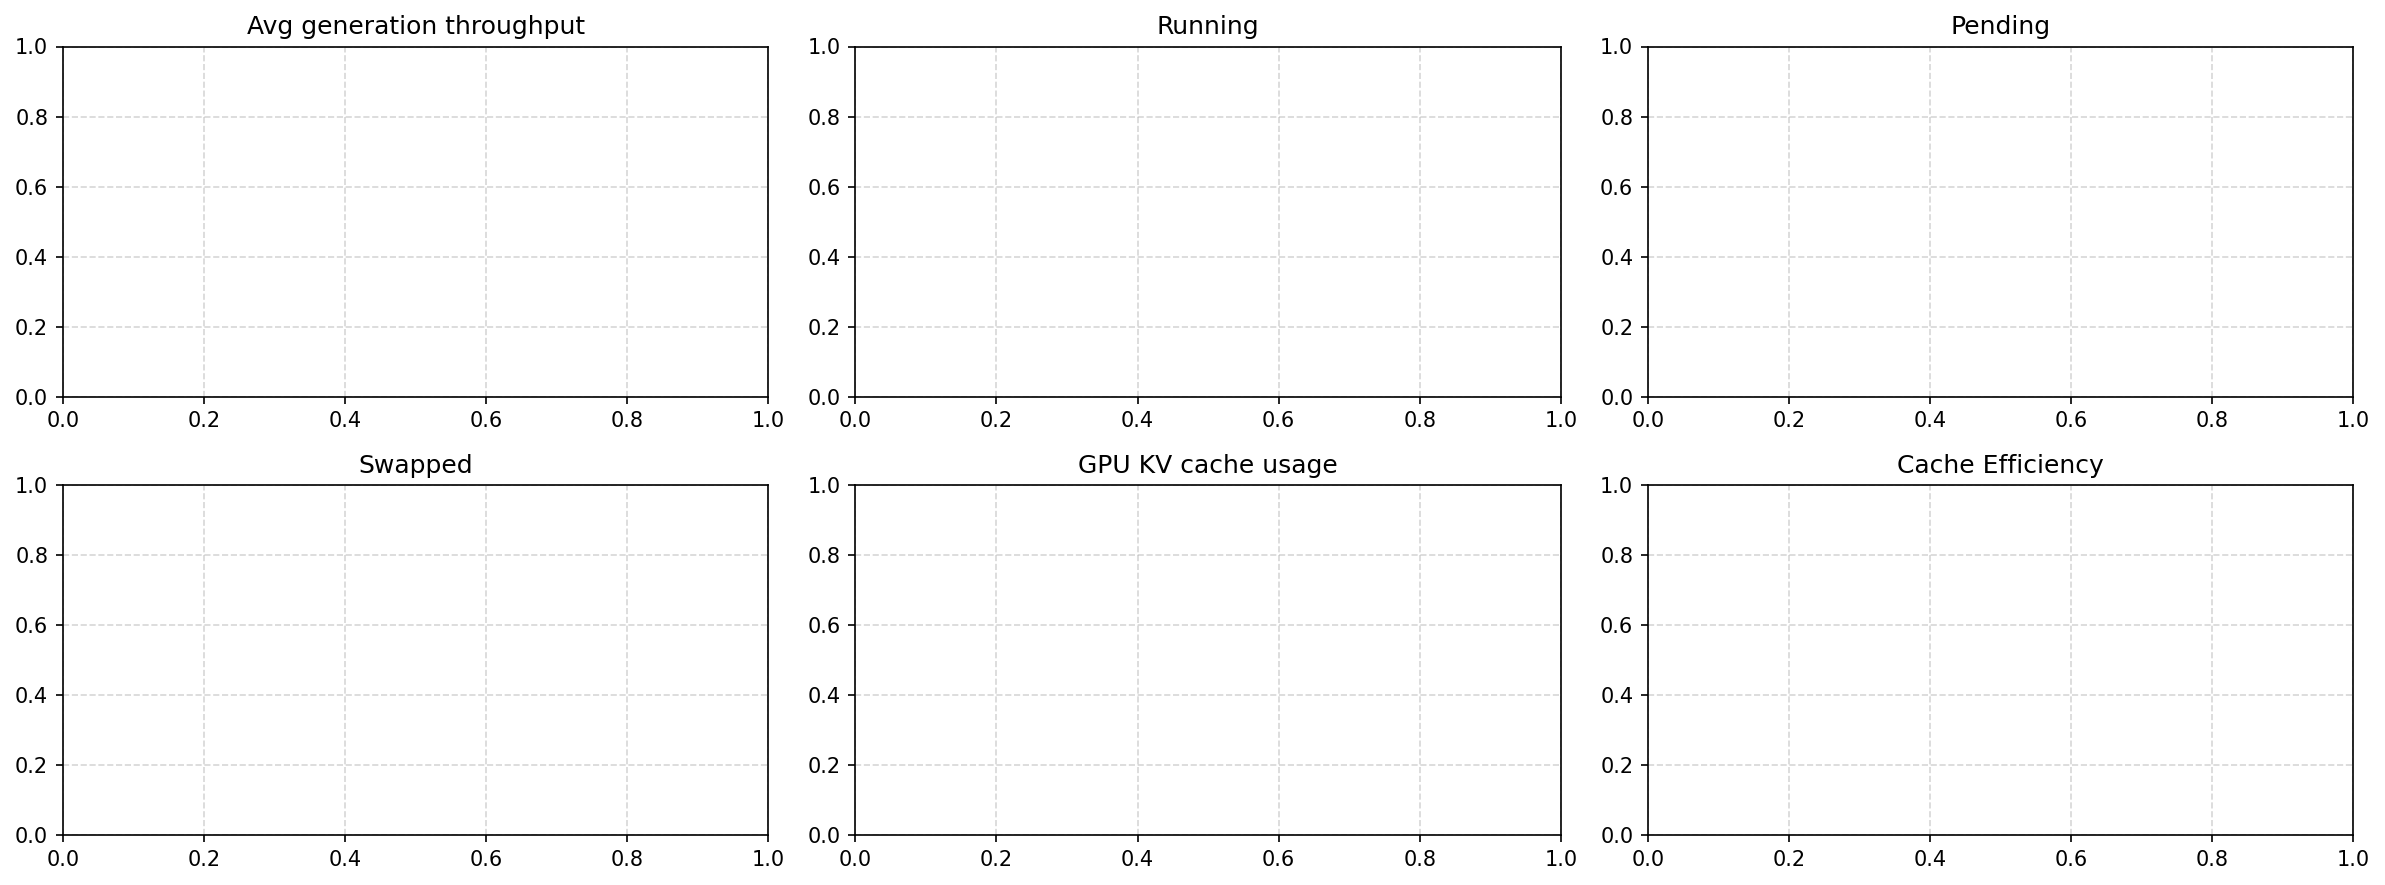

In [120]:
plt.figure(figsize=(16, 6), dpi=150)
# Subplot 1: Avg generation throughput
metric_labels = ["Avg generation throughput", "Running", "Pending", "Swapped", "GPU KV cache usage", "Cache Efficiency"]


for metric_label in metric_labels:
    plt.subplot(2, 3, metric_labels.index(metric_label)+1)
    plt.title(metric_label)
    plt.grid(alpha=0.5, linestyle="--")
    for policy in policies:
        sns.lineplot(
            data=execute_result_dfs[policy],
            x=execute_result_dfs[policy].index,
            y=metric_label,
            label=policy,
        )
plt.tight_layout()
plt.gca()